<a href="https://colab.research.google.com/github/Sidra2499/ETL-Pipeline-for-E-Commerce-Data/blob/main/ETL_Pipeline_for_E_Commerce_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install requests pandas gspread oauth2client


In [2]:
import requests
import pandas as pd

In [4]:
# Public Shopify store API
shop_url = "https://allbirds.com/products.json"

# Fetching data from the API
response = requests.get(shop_url)

if response.status_code == 200:
    data = response.json()
    products = data.get("products", [])

    # Extract relevant fields
    product_data = []
    for product in products:
        name = product.get("title", "N/A")
        vendor = product.get("vendor", "N/A")
        product_type = product.get("product_type", "N/A")
        published_at = product.get("published_at", "N/A").split("T")[0]  # Extract only date

        # Extract price from first variant
        variants = product.get("variants", [])
        price = f"${variants[0]['price']}" if variants else "N/A"

        # Extract first image
        images = product.get("images", [])
        image_url = images[0]["src"] if images else "N/A"

        product_data.append([name, vendor, product_type, published_at, price, image_url])

    # Convert to DataFrame
    df = pd.DataFrame(product_data, columns=["Product Name", "Vendor", "Type", "Published Date", "Price", "Image URL"])

    # Adjust column width for readability
    pd.set_option('display.max_colwidth', 50)

    # Display structured data
    print(df.head(10).to_string(index=False))

else:
    print("❌ Failed to fetch data:", response.status_code)

                                                Product Name   Vendor  Type Published Date  Price                                                                                                                                                                                Image URL
  Women's Tree Gliders - Blizzard/Basin Pink (Blizzard Sole) Allbirds Shoes     2025-02-25 $81.00     https://cdn.shopify.com/s/files/1/1104/4168/files/A11074_24Q3_Tree_Glider_Blizzard_Basin_Pink_Blizzard_PDP_SINGLE_3Q-2000x2000_6b46b2fc-c122-4356-9974-99deb4b2ea76.png?v=1724870125
                Anytime No Show Sock 3-Pack  - Natural Black Allbirds Socks     2025-02-20 $35.00                               https://cdn.shopify.com/s/files/1/1104/4168/files/A11113_S24Q1_Anytime_No_Show_Sock_3_Pack_Natural_Black_Natural_Black_Natural_Black_1__1.png?v=1717430815
                     Anytime No Show Sock 3-Pack  - Blizzard Allbirds Socks     2025-02-20 $35.00                                                 https

In [17]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import requests

# Authenticate and connect to Google Sheets
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name("realtimeetlpipeline-85be1c42ec0c.json", scope)
client = gspread.authorize(creds)

# Open or create a new Google Sheet
gsheet_name = "Shopify-Data"
try:
    sheet = client.open(gsheet_name).sheet1  # Try to open an existing Google Sheet
except gspread.SpreadsheetNotFound:
    sheet = client.create(gsheet_name).sheet1  # Create new sheet if not found
    client.open(gsheet_name).share("sidrakhan2499@gmail.com", perm_type='user', role='writer')

# Fetch public Shopify product data
shopify_url = "https://allbirds.com/products.json"  # Public JSON feed (No API key required)
response = requests.get(shopify_url)

if response.status_code == 200:
    products = response.json().get("products", [])

    # Prepare data for Google Sheets
    data = [["Name", "Vendor", "Type", "Published At", "Price", "Image URL"]]  # Headers
    for product in products:
        name = product.get("title", "N/A")
        vendor = product.get("vendor", "N/A")
        product_type = product.get("product_type", "N/A")
        published_at = product.get("published_at", "N/A")
        price = product["variants"][0]["price"] if product.get("variants") else "N/A"
        image_url = product["images"][0]["src"] if product.get("images") else "N/A"

        data.append([name, vendor, product_type, published_at, price, image_url])

    # Clear and update Google Sheet
    sheet.clear()
    sheet.update("A1", data)

    print("Data successfully stored in Google Sheets!")
else:
    print("Failed to fetch Shopify data:", response.status_code, response.text)


Data successfully stored in Google Sheets!


<ipython-input-17-45c21f5fe663>:39: DeprecationWarning: The order of arguments in worksheet.update() has changed. Please pass values first and range_name secondor used named arguments (range_name=, values=)
  sheet.update("A1", data)


In [18]:
sheet = client.open(gsheet_name).sheet1
allData = sheet.get_all_records()
# Convert to DataFrame
df = pd.DataFrame(allData)
print(df.head())  # Display first few rows

                                                Name    Vendor   Type  \
0  Women's Tree Gliders - Blizzard/Basin Pink (Bl...  Allbirds  Shoes   
1       Anytime No Show Sock 3-Pack  - Natural Black  Allbirds  Socks   
2            Anytime No Show Sock 3-Pack  - Blizzard  Allbirds  Socks   
3          Anytime Ankle Sock 3-Pack - Natural Black  Allbirds  Socks   
4               Anytime Ankle Sock 3-Pack - Blizzard  Allbirds  Socks   

                Published At  Price  \
0  2025-02-25T10:11:58-08:00   81.0   
1  2025-02-20T16:12:31-08:00   35.0   
2  2025-02-20T16:12:17-08:00   35.0   
3  2025-02-20T16:12:00-08:00   38.0   
4  2025-02-20T16:11:48-08:00   38.0   

                                           Image URL  
0  https://cdn.shopify.com/s/files/1/1104/4168/fi...  
1  https://cdn.shopify.com/s/files/1/1104/4168/fi...  
2  https://cdn.shopify.com/s/files/1/1104/4168/fi...  
3  https://cdn.shopify.com/s/files/1/1104/4168/fi...  
4  https://cdn.shopify.com/s/files/1/1104/4168/fi..

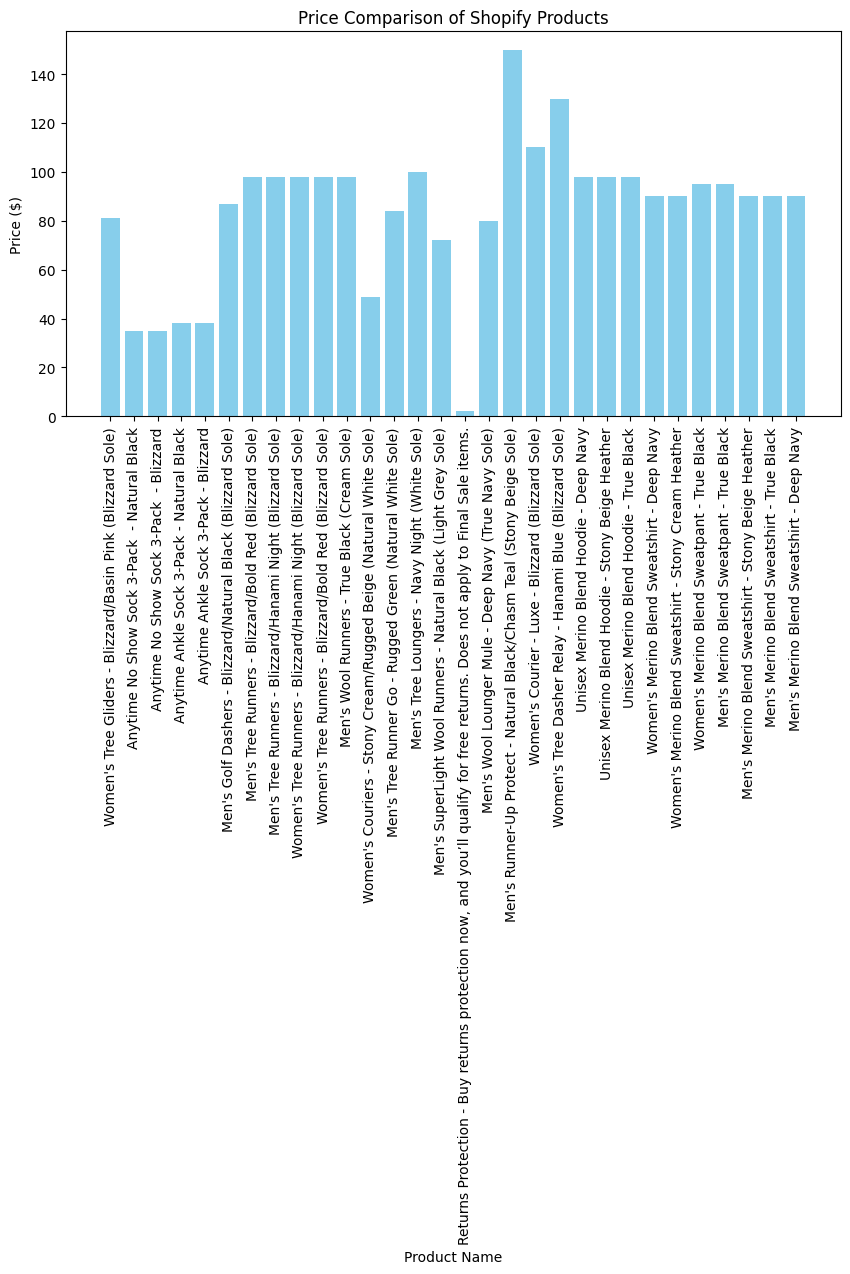

In [19]:
import matplotlib.pyplot as plt

# Convert Price column to numeric
df["Price"] = pd.to_numeric(df["Price"])

# Plot
plt.figure(figsize=(10, 5))
plt.bar(df["Name"], df["Price"], color="skyblue")
plt.xticks(rotation=90)
plt.xlabel("Product Name")
plt.ylabel("Price ($)")
plt.title("Price Comparison of Shopify Products")
plt.show()

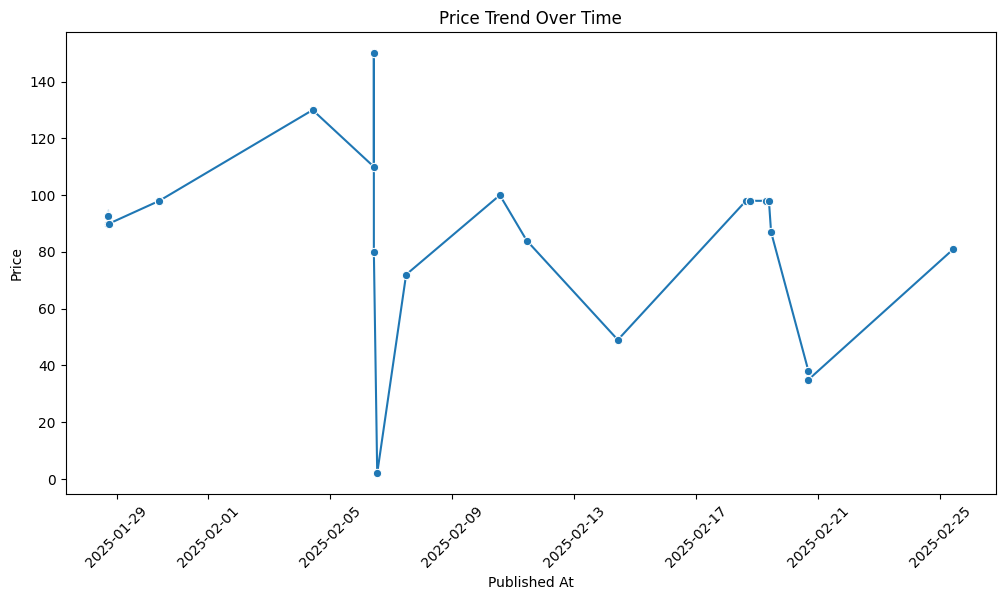

In [20]:
import seaborn as sns

# Convert Published At column to datetime
df["Published At"] = pd.to_datetime(df["Published At"])

# Sort by date
df = df.sort_values("Published At")

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x="Published At", y="Price", data=df, marker="o")
plt.xticks(rotation=45)
plt.title("Price Trend Over Time")
plt.show()

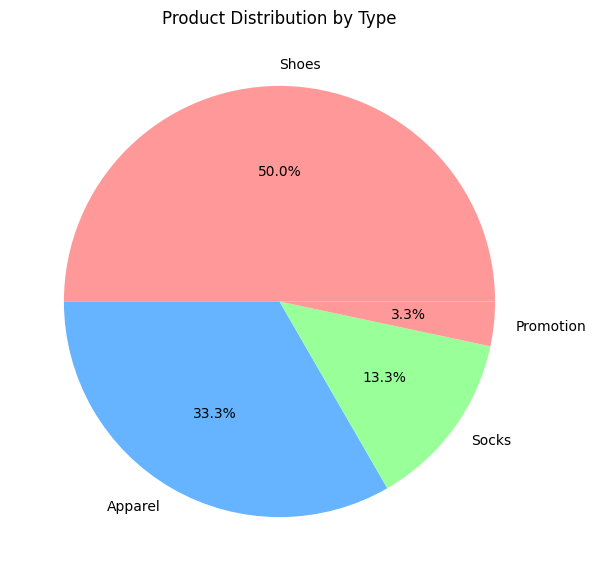

In [21]:
df["Type"].value_counts().plot.pie(autopct="%1.1f%%", figsize=(7, 7),
                                   colors=["#ff9999","#66b3ff","#99ff99"])
plt.title("Product Distribution by Type")
plt.ylabel("")
plt.show()

In [22]:
# Convert to DataFrame
df = pd.DataFrame(data)

# Save to CSV
csv_filename = "shopify_data.csv"
df.to_csv(csv_filename, index=False)

print(f"Data successfully saved as {csv_filename}")

Data successfully saved as shopify_data.csv
